# Accounting for varying irradiance conditions during a drone imaging flight 

### Authors
Leisbeth De Keukelaere <br>
Thomas Jackson  <br>

### Creation Date
14/08/2020


### License
This text and resulting plots are available under Creative Commons BY-NC licence (https://creativecommons.org/licenses/by-nc/4.0/). 
To cite this page, please use the following: <br> 
Jackson, T., Rodero, C., Bardají, R., Piera, J., Liesbeth, De Keukelaere, L., Simis, S. (2020). Demonstration Jupyter Notebooks. H2020 MONOCLE project (Version 1.0) [CODE]. Zenodo. http://doi.org/xxxx/zenodo.xxxxxx

This license does not cover the underlying data and models, please refer to the cited source for their respective licensing. 


## Introduction

Drone technology is a fast evolving market with a lot of potential in different fields. With the correct camera, settings and flight planning, it is possible to derive water-leaving reflectance over water bodies. A couple of important aspects should not be overlooked during this process, including: vignetting effects, solar irradiance, sun and sky glint. If the strengths and limitations of drone technology are well understood, they could be used for validation of satellite data, monitoring near-shore high spatial phenomenon’s or provide gap filling at local scale, when no satellite observation is available. 

One of the big challenges is to correct for changing irradiance conditions during a flight. When the sky is either homogenously covered with clouds or under open-sky conditions, one irradiance measurement is sufficient for the processing of all images from that flight. However, during patchy could conditions, the irradiance can vary significantly over a short time span, and should be measured continuously. Two options are possible to correct for irradiance: 
1.	Work with an irradiance sensor, further referred to as a Downwelling Light Sensor (DLS)
2.	Include spectral calibration panels in the field with known albedo coefficients 
The first option is more favorable than the second, but low-cost drones and cameras often don’t have such a sensor linked to the camera’s spectral characteristics. 

In this demonstration case we compare the irradiance measured by the DLS with the radiance measured over a spectral reference panel with the MicaSense RedEdge-M camera. The spectral reference panel has known spectral characteristics. A small dataset has been gathered throughout two consecutive days with changing solar and sensor angles. 



**Methods and results**

As input of this demonstration, we collected a dataset during two consecutive days (4th and 5th December 2019), capturing simultaneously MicaSense radiance over a spectral reference target with a known reflectance of 20% and DLS irradiance. The processed results were merged in a .csv file with additional information, including drone position and orientation and solar angles.



In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from sklearn.linear_model import LinearRegression

In [2]:
dir_root='./VITO_data/'
file_list=glob.glob(dir_root+'*_20perc.csv', recursive=True)
df=pd.concat([pd.read_csv(f, sep=';') for f in file_list])

print(df.columns)

Index(['Unnamed: 0', 'CaptureName', 'LocalTime', 'UTCTime', 'ExposureTime',
       'ISOSpeed', 'ShutterSpeed', 'Aperture', 'ExposureCorrection',
       'DroneEasting', 'DroneNorthing', 'EPSG_Target', 'DroneRoll',
       'DronePitch', 'DroneYaw', 'RadianceMean', 'RadianceMedian',
       'RadianceSTD', 'RadianceMin', 'RadianceMax', 'IrradianceCorr_DDR6.0',
       'IrradianceCorr_DDR1.0', 'IrradianceCorr_DDR0.1', 'SunSensorAngle',
       'SolarElevation', 'SolarAzimuth'],
      dtype='object')


Three columns of Irradiance values are included, with different DDR levels. DDR stands for Direct Diffuse Ratio. Under open sky conditions, this value can be set at 6.0, while under fully clouded circumstances, this values reduces to 0.1. Choosing the corrected DDR value is a critical part in the processing. RadianceMean, RadianceMedian and RadianceSTD stands for the mean, median and standard deviation of the radiance values observed over the spectral reference panel. 
To intercompare the DLS values [W m<sup>-2</sup> nm<sup>-1</sup>]  with the absolute radiance measured by the MicaSense [W m<sup>-2</sup> sr<sup>-1</sup> nm<sup>-1</sup>], the units have to be aligned. Therefor the radiance is multiplied by pi and divided by 0.2, since the spectral reference panel has a known reflectance of 20% over all bands. Secondly, the correct DDR has to be chosen. During the first day of measurements (04/12/2019) the sky was fully open and no clouds were present (DDR = 6.0). On the second day (05/12/2019) the sky was homogeneously covered with clouds (DDR = 0.1). We create an extra column in the full dataset, containing information of the finally selected irradiance values. 


In [3]:

#Conversion of Rasiance [W m-2 sr-1 nm-1] to Irradiance [W m-2 nm-1]
#Spectral reference target: 20% reflectance
df.RadianceMean*=np.pi/0.2

#Take correct Direct-Diffuse Ratio coefficient
#04/12/2019 : Open sky --> DDr =6.0
#05/12/2019 : Fully clouded --> DDr =0.1

df.UTCTime = pd.to_datetime(df.UTCTime)
df.loc[df.UTCTime.dt.day == 4, 'DLS_Irradiance'] = \
    df.loc[df.UTCTime.dt.day == 4, 'IrradianceCorr_DDR6.0']

df.loc[df.UTCTime.dt.day == 5, 'DLS_Irradiance'] = \
    df.loc[df.UTCTime.dt.day == 5, 'IrradianceCorr_DDR0.1']




A scatterplot of DLS irradiance versus MicaSense derived irradiance can be obtained. The 1:1 line is added in black. Four spectral bands (i.e. Blue, Green, Red and RedEdge) follow the 1:1 line, only the NIR spectral band deviates significantly from this line for all measurements. An explanation if the difference in spectral response curves between the NIR present in the DLS compared to the one of the MicaSense RedEdge-M camera. 

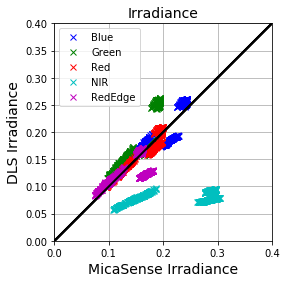

In [4]:
np_colorAbbrev = np.array(['b','g','r','c','m'])
np_colorName = np.array(['Blue','Green','Red','NIR','RedEdge'])

fig,ax=plt.subplots(nrows=1, ncols=1, sharex=True)
for i in np.arange(1,6):
    df_band = df.loc[df.iloc[:,0].str.endswith('_'+str(i)),:]
    ax.plot(df_band.loc[:,'RadianceMean'], df_band.loc[:,'DLS_Irradiance'], \
           np_colorAbbrev[i-1]+'x', label=np_colorName[i-1])
    ax.plot([0,1],[0,1], 'k-', lw=2)
    ax.set_ylabel('DLS Irradiance', fontsize=14)
    ax.set_xlabel('MicaSense Irradiance', fontsize=14)
    ax.set_ylim(0,0.4)
    ax.set_xlim(0,0.4)
    ax.set_aspect('equal', adjustable='box')
    ax.legend(loc=0)
    ax.grid(which='both', axis='both')
    ax.set_title('Irradiance', fontsize=14)
    

The regression coefficients underline our first observation of a weak performance in the NIR band, see code below. A slope value of only 0.07 is obtained and an R² of 0.269. But also the Red Edge band does not perform well and retrieves a slope of 0.56, an intercept of 0.054 and a coefficient of determination of 0.48. The three visible bands show a coefficient of determination larger than 0.7

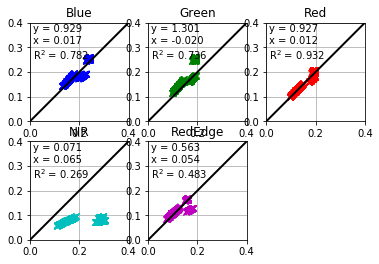

In [5]:
Bandnames = np_colorName = np.array(['Blue','Green','Red','NIR','RedEdge'])

fig = plt.figure()
for i in np.arange(1,6):
    df_band = df.loc[df.iloc[:,0].str.endswith('_'+str(i)),:]
    
    #perform a linear regression
    
    x = df_band.loc[:,'RadianceMean'].values.reshape((-1,1))
    y = df_band.loc[:,'DLS_Irradiance']
    model = LinearRegression().fit(x,y)
    
    r_sq = model.score(x,y)
    ax=fig.add_subplot(230+i, aspect='equal')
    ax.plot(df_band.loc[:,'RadianceMean'], df_band.loc[:,'DLS_Irradiance'], \
           np_colorAbbrev[i-1]+'x')
    ax.plot([0,1],[0,1], 'k-', lw=2)
    ax.set_ylim(0,0.4)
    ax.set_xlim(0,0.4)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(which='both', axis='both')
    ax.text(0.01,0.25, 'y = %.03f \nx = %.03f \nR$^2$ = %.03f' %(model.coef_, \
            model.intercept_, r_sq))
    ax.set_title(Bandnames[i-1])

To observe a possible anomaly or detect a wrong set-up during measurements, the ratio between the DLS and the MicaSense derived was calculated. Ideally this should be a fixed value. However, in the example given we see an abrupt change in this ratio values on the first day (04/12/2019). This change can be linked to the resetting of the set-up. We will have to investigate further why this change in set-up impacted the results significantly. On the second day, when the sky was fully clouded (05/12/2019) similar ratio values were obtained as during the first day, except for the green band.

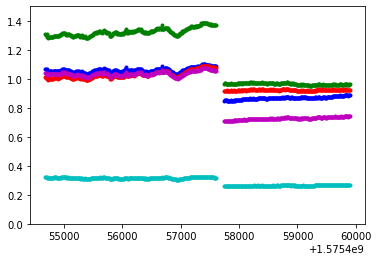

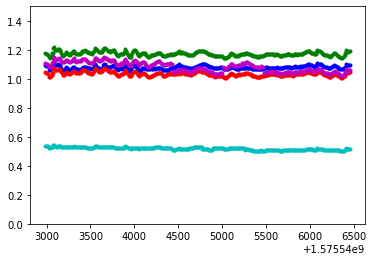

In [6]:
df.loc[:,'DLS_Micasense_Ratio'] = df.DLS_Irradiance / df.RadianceMean

for i in np.arange(4,6):
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
    df_sub = df[df.UTCTime.dt.day == i]
    for j in np.arange(1,6):
        df_band = df_sub.loc[df_sub.iloc[:,0].str.endswith('_'+str(j)),:]
        ax.plot(df_band.loc[:,'LocalTime'], df_band.loc[:,'DLS_Micasense_Ratio'], \
        np_colorAbbrev[j-1]+'.')
        ax.set_ylim(0,1.5)
        


**Summary**

The irradiance is a crucial parameter in drone data processing. There are two methods to obtain this information: through an additional irradiance sensors, such as the DLS demonstrated in this exercise, or using spectral reference targets with known albedo in the field. In this exercise we compared both datasets, so check any inconsistencies between both method. By taking the ratio of both datasets, it’s possible to determine if one of the sensors shifts over time or, as was the case here, if a wrong set-up was used. We have to investigate further the reasoning behind this abrupt change caused by a change in camera and sensor set-up.  
